# Strain-gauage ADCs: HX711, ADS1232, ADS1220 Comparison Test

<img width=300px align=right src=test_system.jpg> 
This comparison test is meant to find a decision key 
    for choosing the ADC among __HX711, ADS1232, and ADS1220__ for measurement of __strain gauge__.

The experiment focuses on the question about precision on each ADC.
Diffence between read values on same weight should be aware.

In experiment, the sensor, ADC, and microcontroller are connected as the system shown in the right figure.

<img width=300px align=left src=eqv_loadcell.jpg> 
These ADCs are designed to interface with such kind of sensor 
    which changes the output voltage slightly in comparison with the excitation voltage.
Thus, each of them has already been embedded a differential amplifier as the front-end
    to connect with an external __Wheatstone-bridge__ circuit integrated with the strain gauge.

The mentioned bridge circuit, as shown on the left figure, 
    has already been embedded in the device that is called __loadcell__.
In experiment, each of ADCs was connected with a loadcell and measured values of standard weights.

## Experiment

### Objective

* To compare the precision among HX711, ADS1232, and ADS1220.

### Setup

<img width=300px align=left src=testbed.jpg>
<img width=400px align=right src=../documents/imas_cjmcu_hx711_ads1232_ads1220.png>

In the left figure, 
    in spite of phototyping the board just for experimentation, 
    the testbed was powerred by lab-graded power supply due to the measurment quality.

The __schematic__ shown on the right explains the prototype circuit on the left.

<img width=300px align=right src=standard_weights.jpg>

The loadcell used in this test plays a part as scale, as shown in the figure on the right.
Standard weights: __5, 10, 20, 50, and 100 grams__ were read by the ADCs under test.
Each weight were __measured 20 times__ for examining precision of each ADCs throught __mean and varience__ calculations.

### Method

1. Experiment each ADC by __connecting__ the __only one loadcell__ to one of ADC: HX711, ADS1232, and ADS1220.
1. __Calibrate__ the connected system with __100g standard weight__.
1. __Read__ the value from ADC __20 times__.

### Result

In [1]:
result_paths_hx711   = "HX711.txt"
result_paths_ads1232 = "ADS1232.txt"
result_paths_ads1220 = "ADS1220.txt"
result_paths = {'HX711'   : result_paths_hx711, 
                'ADS1232' : result_paths_ads1232, 
                'ADS1220' : result_paths_ads1220}

tested_weights = [0, 5, 10, 20, 50, 100]

#### Script

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import re, os
import numpy as np
import pandas as pd
import matplotlib, datetime
import matplotlib.pyplot as plt

In [4]:
matplotlib.rc('text', usetex=True)
matplotlib.rc('font',**{'family':'sans-serif', 'sans-serif':['Times New Roman'], 'size':10})

In [5]:
def get_data_from_file(fpath):
    f = open(fpath, 'r')
    results = {}
    data = []
    re_temp = re.compile(r'\[(?P<no>[\d]+)\] [\d\w]+: raw=(?P<raw>[\d-]+) volt=(?P<volt>[\d.-]+)mV mass=(?P<mass>[\d.-]+)g')
    re_dash = re.compile(r'^-+$')
    
    line = f.readline()
    while line:
        line = f.readline() # Already skipped the first line
        found = re_temp.search(line)
        if found is not None:
            data.append(found.groupdict())
        elif re_dash.match(line):
            k = int(round(np.mean([float(l['mass']) for l in data]), 0))  # Guess the tested standard weight as the key
            
            abs_diff = lambda list_value : abs(list_value - k)
            c = min(tested_weights, key=abs_diff)  # Find the nearest value from the weights to k
            
            results[c] = data
            data = []
            
            #print k, c

    return results

In [6]:
def make_df_from_file(fpath, sel='mass'):
    results = get_data_from_file(fpath)
    sel_results = { std_weight:
                   {
#                        'mean': np.mean([ float(t[sel]) for t in tests ]),
                       'std' : np.std( [ float(t[sel]) for t in tests ])
#                         i: float(t[sel]) for i, t in enumerate(tests)
                   }
                   for std_weight, tests in results.items() }
    return pd.DataFrame(sel_results)

#### Data

In [7]:
df_mass = pd.concat([ make_df_from_file(p).transpose().rename(columns={'std':k}) 
                     for k, p in result_paths.items() ], sort=False, axis=1, join='outer')

In [8]:
df_mass

,HX711,ADS1232,ADS1220
0,0.030622,0.057854,0.032238
5,0.095268,0.042845,0.072913
10,0.012816,0.103328,0.055197
20,0.020304,0.060594,0.010109
50,0.009610,0.101487,0.020150
100,0.011463,0.070893,0.038346


#### Plot

Text(0,0.5,'Stardard Deviation of 20-time read values')

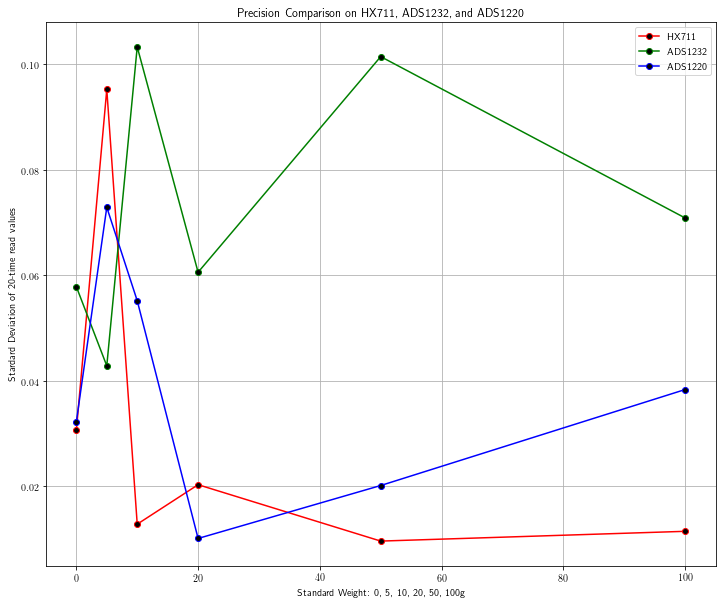

In [11]:
ax = df_mass.plot(title='Precision Comparison on HX711, ADS1232, and ADS1220',
                  grid=True, color='rgb', figsize=(12,10), 
                  markevery=1, marker='o', markerfacecolor='black')
ax.set_xlabel('Standard Weight: 0, 5, 10, 20, 50, 100g')
ax.set_ylabel('Stardard Deviation of 20-time read values')

## Conclustion

The result shows that __HX711__ got the best precise reading comparatively to ADS1232 and ADS1220.

Despite slightly losing, __ADS1220__ sampled values at 20-SPS, faster than the others that did at 10-SPS.
Additionally, it can increase the rate upto 2k-SPS.
Therefore, in the case that more sampling rate is required, ADS1220 probably be the answer. 

---